<a href="https://colab.research.google.com/github/shailavij/Neural_translational_Model/blob/master/GERMAN_ENGLISH_NMT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone project 
# Neural Translation model
This neural network that translates from German to English

In [1]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.


In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%cd /content/gdrive/My Drive/DL_DATASet/

/content/gdrive/My Drive/DL_DATASet


# Read Data
Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.


In [0]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\t'



In [0]:
# Split the text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [22]:
from numpy import array, argmax, random, take

data=read_text('deu.txt')
deu_eng= to_lines(data)
deu_eng = array(deu_eng)
deu_eng= deu_eng[:50000,:]
len(deu_eng)

deu_eng[0]



array(['Hi.', 'Hallo!',
       'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
      dtype='<U537')

In [0]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [0]:
deu_eng= deu_eng[:,0:2]

In [0]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [26]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['i wholeheartedly agree', 'ich stimme rückhaltlos zu'],
       ['i will always love you', 'ich werde dich immer lieben'],
       ['i will be back by nine', 'um neun bin ich wieder zurück']],
      dtype='<U537')


Text to Sequence Conversion
To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively

In [0]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [28]:
length_df= pd.DataFrame({'eng': eng_l , 'deu':deu_l})
length_df
print("Length of Eng_sentence",max(eng_l))
print("Length of German_sentence",max(deu_l))

Length of Eng_sentence 7
Length of German_sentence 15


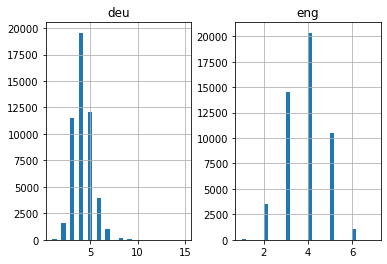

In [29]:
length_df.hist(bins=30)
plt.show()


The maximum length of the German sentences is 10 and that of the English phrases is 5.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.


In [0]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [33]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 5
print('English Vocabulary Size: %d' % eng_vocab_size)


English Vocabulary Size: 6361


In [34]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 10
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10597


 Function to prepare the sequences, It will also perform sequence padding to a maximum sentence length as mentioned above.

In [0]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [0]:
# Model Building
#now split the data into train and test set for model training and evaluation, respectively.


from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

# Model Building
#now split the data into train and test set for model training and evaluation, respectively.




In [0]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Now encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [44]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
print("trainx",trainX.shape)
print("trainY",trainY.shape)

trainx (40000, 10)
trainY (40000, 5)


In [0]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [0]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [45]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')
print(trainX.shape)
model.summary()

(40000, 10)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 10, 512)           5425664   
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 5, 512)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 5, 512)            2099200   
_________________________________________________________________
dense_3 (Dense)              (None, 5, 6361)           3263193   
Total params: 12,887,257
Trainable params: 12,887,257
Non-trainable params: 0
_________________________________________________________________


In [47]:

filename = 'model.h1.30_May_20'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 201s 6ms/step - loss: 5.1016 - val_loss: 4.6170

Epoch 00001: val_loss improved from inf to 4.61704, saving model to model.h1.30_May_20
Epoch 2/30
32000/32000 [==============================] - 196s 6ms/step - loss: 4.4501 - val_loss: 4.4477

Epoch 00002: val_loss improved from 4.61704 to 4.44775, saving model to model.h1.30_May_20
Epoch 3/30
32000/32000 [==============================] - 196s 6ms/step - loss: 4.1336 - val_loss: 4.1509

Epoch 00003: val_loss improved from 4.44775 to 4.15085, saving model to model.h1.30_May_20
Epoch 4/30
32000/32000 [==============================] - 198s 6ms/step - loss: 3.8795 - val_loss: 3.9488

Epoch 00004: val_loss improved from 4.15085 to 3.94883, saving model to model.h1.30_May_20
Epoch 5/30
32000/32000 [==============================] - 198s 6ms/step - loss: 3.6796 - val_loss: 3.8180

Epoch 00005: val_loss improved from 3.94883 to 3.81801, 

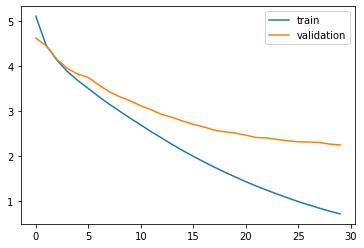

In [49]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

Make Predictions 

Let's load the saved model to make predictions

In [50]:
model = load_model('model.h1.30_May_20')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))
preds

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


array([[  3, 102, 159,  61,   0],
       [  2,  73, 133,   0,   0],
       [  2, 356,  96,   1,   0],
       ...,
       [  1,   4,   5,  85, 794],
       [ 54, 175,   3,  68,   0],
       [ 39,  27,  20,  87,   1]])

In [0]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [0]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [0]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [0]:
pd.set_option('display.max_colwidth', 100)

In [55]:
pred_df.head(15)

,actual,predicted
0,you need to wake up,you must stay now
1,i feel old,i am bad
2,im sorry tom,i sorry about tom
3,hide the money,is the money
4,is someone calling me,let me
5,you should work hard,you should work hard
6,tom has a big problem,tom has a bad nose
7,he lives with his mom,he lives her
8,whats toms job,whats your job
9,i dont want to drive,i dont want to go
